In [1]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler

In [2]:
crime_schema = StructType([StructField("IncidentName",IntegerType(),True),
                          StructField("Category",StringType(),True),
                          StructField("Descript",StringType(),True),
                          StructField("DayofWeek",StringType(),True),
                          StructField("Date",StringType(),True),
                          StructField("Time",StringType(),True),
                          StructField("PdDistrict",StringType(),True),
                          StructField("Resolution",StringType(),True),
                          StructField("Address",StringType(),True),
                          StructField("X",DoubleType(),True),
                          StructField("Y",DoubleType(),True),
                          StructField("Location",StringType(),True),
                          StructField("PdID",StringType(),True)])

In [3]:
# Load and parse the data file, converting it to a DataFrame.
crimeDF = spark.read.csv('s3a://crimedatafyp/crimeData/*.csv',header=True,schema=crime_schema)
crimeDF.count()

2215016

In [4]:
dropList = ["IncidentName","Descript","Resolution","Location","PdID","X","Y"]
crimeDF = crimeDF.select([column for column in crimeDF.columns if column not in dropList])
crimeDF.printSchema()

root
 |-- Category: string (nullable = true)
 |-- DayofWeek: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- PdDistrict: string (nullable = true)
 |-- Address: string (nullable = true)



In [5]:
from pyspark.sql.functions import *
crimeNewDF = crimeDF.withColumn('Year',year(unix_timestamp('Date', 'MM/dd/yyyy').cast("timestamp")))\
                    .withColumn('Month',month(unix_timestamp('Date', 'MM/dd/yyyy').cast("timestamp")))\
                    .withColumn('Day',dayofmonth(unix_timestamp('Date', 'MM/dd/yyyy').cast("timestamp")))\
                    .withColumn('Hour',hour('Time'))

In [13]:
crimeNewDF=crimeNewDF.drop('Date').drop('Time').drop('X').drop('Y')
crimeNewDF.printSchema()

root
 |-- Category: string (nullable = true)
 |-- DayofWeek: string (nullable = true)
 |-- PdDistrict: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Day: integer (nullable = true)
 |-- Hour: integer (nullable = true)



In [7]:
cat_cols = [item[0] for item in crimeNewDF.dtypes if item[1].startswith('string')] 
num_cols = [item[0] for item in crimeNewDF.dtypes if item[1].startswith('int') | item[1].startswith('double')][1:]

In [17]:
crimeNewDF=crimeNewDF.filter(crimeNewDF.PdDistrict.isNotNull())

In [20]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer,IndexToString,VectorAssembler,OneHotEncoderEstimator
from pyspark.ml.linalg import Vectors
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

(trainingData,testData) = crimeNewDF.randomSplit([0.7,0.3],seed= 100)

catIndexer = StringIndexer(inputCol="Category",outputCol="label",handleInvalid='keep').fit(trainingData)

indexers = [StringIndexer(inputCol= column, outputCol=column+"_index").fit(crimeNewDF) for column in list(set(crimeNewDF.columns)-set(['Year','Month','Day','Hour','Category']))]

#encoders = [OneHotEncoderEstimator(
 #   inputCols=[indexer.getOutputCol()],
  #  outputCols=[indexer.getOutputCol()+"_encoded"]) for indexer in indexers]

assemblerInputs = [column + "_index" for column in list(set(crimeNewDF.columns)-set(['Year','Month','Day','Hour','Category']))] + num_cols

assembler = VectorAssembler(
            inputCols=assemblerInputs,
            outputCol="features")

rf =  RandomForestClassifier(labelCol="label",featuresCol="features",numTrees = 100, maxDepth=4,maxBins=25147)

labelConverter = IndexToString(inputCol="prediction",outputCol="predictedLabel",labels=catIndexer.labels)

pipeline = Pipeline(stages=indexers+[catIndexer,assembler,rf,labelConverter])#+encoders

model = pipeline.fit(trainingData)

predictions = model.transform(testData)

predictions.printSchema()

#predictions.select("predictedLabel","Label","features").show(5)

#evaluator = MulticlassClassificationEvaluator(
#    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
#accuracy = evaluator.evaluate(predictions)

root
 |-- Category: string (nullable = true)
 |-- DayofWeek: string (nullable = true)
 |-- PdDistrict: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Day: integer (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- DayofWeek_index: double (nullable = false)
 |-- PdDistrict_index: double (nullable = false)
 |-- Address_index: double (nullable = false)
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)
 |-- predictedLabel: string (nullable = true)



In [21]:
predictions.select("label","features","probability").show(5)

+-----+--------------------+--------------------+
|label|            features|         probability|
+-----+--------------------+--------------------+
| 27.0|[0.0,3.0,1779.0,1...|[0.22431707197869...|
| 27.0|[0.0,5.0,4368.0,1...|[0.15760357952753...|
| 27.0|[0.0,5.0,8286.0,7...|[0.19753874929348...|
| 27.0|[0.0,9.0,8129.0,2...|[0.24945040887862...|
| 27.0|[5.0,4.0,216.0,1....|[0.12697343302239...|
+-----+--------------------+--------------------+
only showing top 5 rows



In [22]:
model_predictions = predictions.select(['features','label','Category'])

In [23]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

In [24]:
print(accuracy)

0.233919951805


In [25]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
paramGrid = ParamGridBuilder()\
            .addGrid(rf.impurity,["entropy","gini"])\
            .build()
        
cv = CrossValidator(estimator = pipeline,\
                   estimatorParamMaps=paramGrid,\
                   evaluator=evaluator,\
                   numFolds=5)

cvModel = cv.fit(trainingData)

predictions = cvModel.transform(testData)


In [26]:
#check the importance of each feature
importances = cvModel.bestModel.stages[5].featureImportances

In [27]:
x_values = list(range(len(importances)))

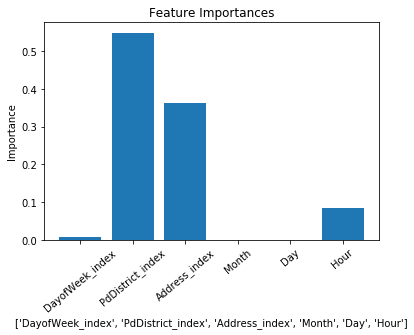

In [44]:
import matplotlib.pyplot as plt
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, assemblerInputs, rotation=40)
plt.ylabel('Importance')
plt.xlabel(assemblerInputs)
plt.title('Feature Importances')
plt.show()

In [42]:
from pyspark.mllib.evaluation import MulticlassMetrics
results = predictions.select(['prediction','label'])
predictionAndLabels = results.rdd
metrics = MulticlassMetrics(predictionAndLabels)

cm=metrics.confusionMatrix().toArray()
accuracy=(cm[0][0]+cm[1][1])/cm.sum()
precision=(cm[0][0])/(cm[0][0]+cm[1][0])
recall=(cm[0][0])/(cm[0][0]+cm[0][1])
print("RandomForestClassifier:\naccuracy:{}\nprecision:{}\nrecall:{}".format(accuracy,precision,recall))

RandomForestClassifier:
accuracy:0.220047441545
precision:0.648130894105
recall:0.94175710039


In [31]:
FScore = 2*precision*recall/(precision+recall)
print("F1 Score: {0} ".format(FScore))

F1 Score: 0.767830027799 


In [30]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.558499187874
